## Пункт 11

«Творческое задание» на поиск аномалий. Загрузите файл `mnist_small.csv`. Данный набор данных содержит подмножество эталонного набора данных рукописных цифр MNIST. 5923 картинок 28x28 пикселей с изображением нуля и 76 картинок с изображением шестерки. Задача состоит в том, чтобы с использованием метода `SVM` построить одноклассовую модель на основе поиска аномалий, которая максимально хорошо отфильтрует шестерки (как аномалии) от нулей (как основной выборки). Признаки картинок описываются их координатами (в названии переменных, например «10x12») и значением яркости точки по этим координатам. Подбирая параметры метода и преобразуя признаки как посчитаете нужным, но не используя при этом информацию о label, постройте модель выявления аномалий с ERR меньше 0.2.

In [39]:
import pandas as pd
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# Загрузка данных
data = pd.read_csv('mnist_small.csv')

# Разделение на признаки и метки
X = data.drop(columns=['label'])
y = data['label']

# Нормализация данных
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на нули (основная выборка) и шестерки (аномалии)
X_zeros = X_scaled[y == 0]
X_sixes = X_scaled[y == 6]

model = OneClassSVM(nu=0.05, kernel='rbf', gamma='auto')
model.fit(X_zeros)

# Предсказание для нулей и шестерок
pred_zeros = model.predict(X_zeros)
pred_sixes = model.predict(X_sixes)

# Оценка модели
# 1 для нормальных данных, -1 для аномалий
tn, fp, fn, tp = confusion_matrix(
    y_true=np.concatenate([np.ones(len(X_zeros)), -np.ones(len(X_sixes))]),
    y_pred=np.concatenate([pred_zeros, pred_sixes]),
    labels=[1, -1]
).ravel()

# Вычисление ошибки ERR (False Negative Rate для аномалий)
err = fn / (fn + tp)
print(f"ERR: {err:.4f}")

# Дополнительная информация
print(f"Число нулей: {len(X_zeros)}")
print(f"Число шестерок: {len(X_sixes)}")
print(f"Нули, ошибочно классифицированные как аномалии: {fp}")
print(f"Шестерки, ошибочно классифицированные как нули: {fn}")

ERR: 0.1053
Число нулей: 5923
Число шестерок: 76
Нули, ошибочно классифицированные как аномалии: 294
Шестерки, ошибочно классифицированные как нули: 8


## Пункт 12

Постройте ROC кривую с ERR. Выведите 4 картинки с числами (28 на 28 пикселей):  

- самый типичный “0” – true negative с минимальной аномальностью 
- самая аномальная “6” – true positive с максимальной аномальностью 
- самый нетипичный “0” – false positive с максимальной аномальностью 
- самая неаномальная “6” – false negative с минимальной аномальностью

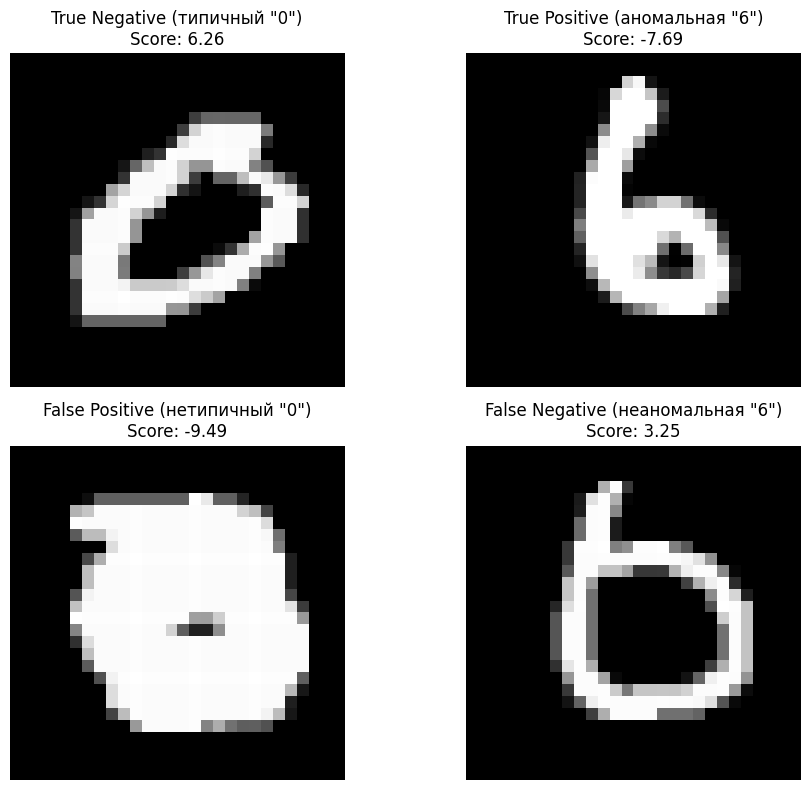

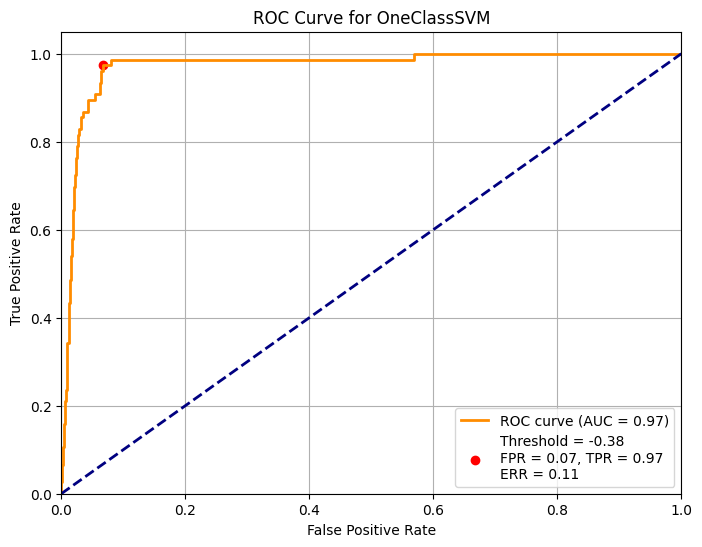

In [41]:
import matplotlib.pyplot as plt

# Получение оценок аномальности (чем меньше значение, тем более аномальный объект)
scores = model.decision_function(X_scaled)

# Разделение scores на нули и шестерки
scores_zeros = scores[y == 0]
scores_sixes = scores[y == 6]

# Находим индексы для каждого случая
# True Negative (самый типичный "0" - минимальная аномальность)
tn_idx = np.argmax(scores_zeros)  # argmax, т.к. decision_function возвращает большие значения для "нормальных" объектов
# True Positive (самая аномальная "6" - минимальный score)
tp_idx = np.argmin(scores_sixes)
# False Positive (самый нетипичный "0" - минимальный score)
fp_idx = np.argmin(scores_zeros)
# False Negative (самая неаномальная "6" - максимальный score)
fn_idx = np.argmax(scores_sixes)

# Визуализация
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.imshow(X_zeros[tn_idx].reshape(28, 28), cmap='gray')
plt.title(f'True Negative (типичный "0")\nScore: {scores_zeros[tn_idx]:.2f}')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(X_sixes[tp_idx].reshape(28, 28), cmap='gray')
plt.title(f'True Positive (аномальная "6")\nScore: {scores_sixes[tp_idx]:.2f}')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(X_zeros[fp_idx].reshape(28, 28), cmap='gray')
plt.title(f'False Positive (нетипичный "0")\nScore: {scores_zeros[fp_idx]:.2f}')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(X_sixes[fn_idx].reshape(28, 28), cmap='gray')
plt.title(f'False Negative (неаномальная "6")\nScore: {scores_sixes[fn_idx]:.2f}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Построение ROC-кривой
from sklearn.metrics import roc_curve, auc

# Создаем метки: 0 для нулей, 1 для шестерок
y_true = np.concatenate([np.zeros(len(X_zeros)), np.ones(len(X_sixes))])
# Используем отрицательные scores, так как меньшие значения decision_function соответствуют аномалиям
y_scores = -scores

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', 
            label=f'Threshold = {optimal_threshold:.2f}\nFPR = {fpr[optimal_idx]:.2f}, TPR = {tpr[optimal_idx]:.2f}\nERR = {err:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for OneClassSVM')
plt.legend(loc="lower right")
plt.grid()
plt.show()